# Notebook 02: Preprocessing & Normalization

**Objective**: Normalize and preprocess single-cell data to make cells comparable.

## What you will learn:
- Why normalization is necessary
- Different normalization strategies
- Log transformation and its importance
- Identifying highly variable genes (HVGs)
- When and why to scale data

## Key Concepts:

### Why Normalize?
Different cells have different **sequencing depths** (total counts). Normalization makes cells comparable by accounting for these technical differences.

### Workflow:
1. Load filtered data from Notebook 01
2. Normalize counts (account for sequencing depth)
3. Log transform (stabilize variance)
4. Identify highly variable genes
5. Compute PCA (on log-normalized data)
6. Scale data (for other downstream analyses)
7. Save preprocessed data

In [1]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Filtered Data

Load the filtered dataset from Notebook 01.

In [2]:
# Load filtered data from Notebook 01
adata = sc.read_h5ad(f'{data_dir}pbmc3k_filtered.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"\n📊 Dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

📊 Dimensions: 2689 cells × 13671 genes


## 2. Normalization

### Method: Total-count normalization (Library-size normalization)

**Formula**: normalized_count = (count / total_counts_per_cell) × target_sum

**What it does**:
- Each cell is scaled to have the same total counts (target_sum)
- Default in Scanpy: **target_sum = 10,000**
- Makes cells with different sequencing depths comparable
- Preserves relative gene expression within each cell

**Why 10,000?**
- More intuitive for single-cell data than 1 million (CPM)
- Easier to interpret (e.g., "50 counts out of 10,000" = 0.5%)
- Mathematically equivalent to CPM, just different scale

**Example**:
- Cell A: 1,000 total counts, Gene X = 10 counts → normalized = 100
- Cell B: 10,000 total counts, Gene X = 10 counts → normalized = 10
- Now we can see Gene X is more important in Cell A!

normalizing counts per cell
    finished (0:00:00)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


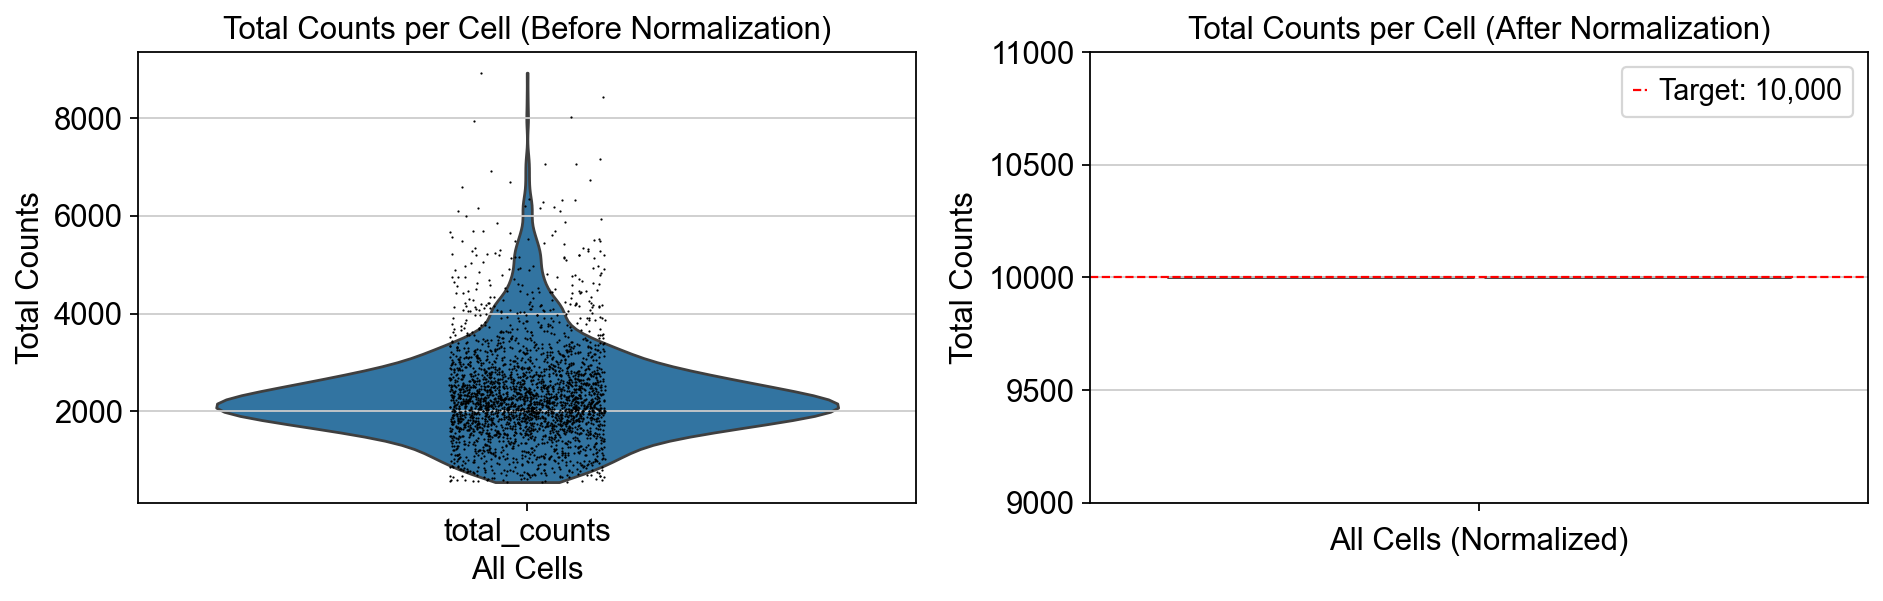

Normalization complete!
Target sum: 10,000 counts per cell
Mean: 10000.0, Min: 10000.0, Max: 10000.0


In [3]:
# Visualize total counts before normalization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before normalization
sc.pl.violin(adata, 'total_counts', ax=axes[0], show=False)
axes[0].set_title('Total Counts per Cell (Before Normalization)')
axes[0].set_ylabel('Total Counts')
axes[0].set_xlabel('All Cells')

# Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# After normalization - recalculate total counts
import scipy.sparse as sp
if sp.issparse(adata.X):
    total_after = np.array(adata.X.sum(axis=1)).flatten()
else:
    total_after = adata.X.sum(axis=1)

# Create a temporary dataframe for plotting
temp_df = pd.DataFrame({'total_counts_normalized': total_after})

# Plot using seaborn
sns.violinplot(data=temp_df, y='total_counts_normalized', ax=axes[1], color='steelblue')
axes[1].set_title('Total Counts per Cell (After Normalization)')
axes[1].set_ylabel('Total Counts')
axes[1].set_xlabel('All Cells (Normalized)')
axes[1].set_ylim([9000, 11000])
axes[1].axhline(y=10000, color='red', linestyle='--', linewidth=1, label='Target: 10,000')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{results_dir}02_normalization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Normalization complete!")
print(f"Target sum: 10,000 counts per cell")
print(f"Mean: {total_after.mean():.1f}, Min: {total_after.min():.1f}, Max: {total_after.max():.1f}")

## 3. Log Transformation

### Why log transform?

**Problem**: Gene expression is highly skewed
- Most genes: low expression (0-10 counts)
- Few genes: very high expression (1000+ counts)

**Solution**: Log transformation compresses the range

**Formula**: `log(count + 1)`
- The "+1" prevents log(0) = -infinity

**Benefits**:
- Stabilizes variance across expression levels
- Makes data more normally distributed
- Improves downstream analysis (PCA, clustering)
- Reduces impact of outliers

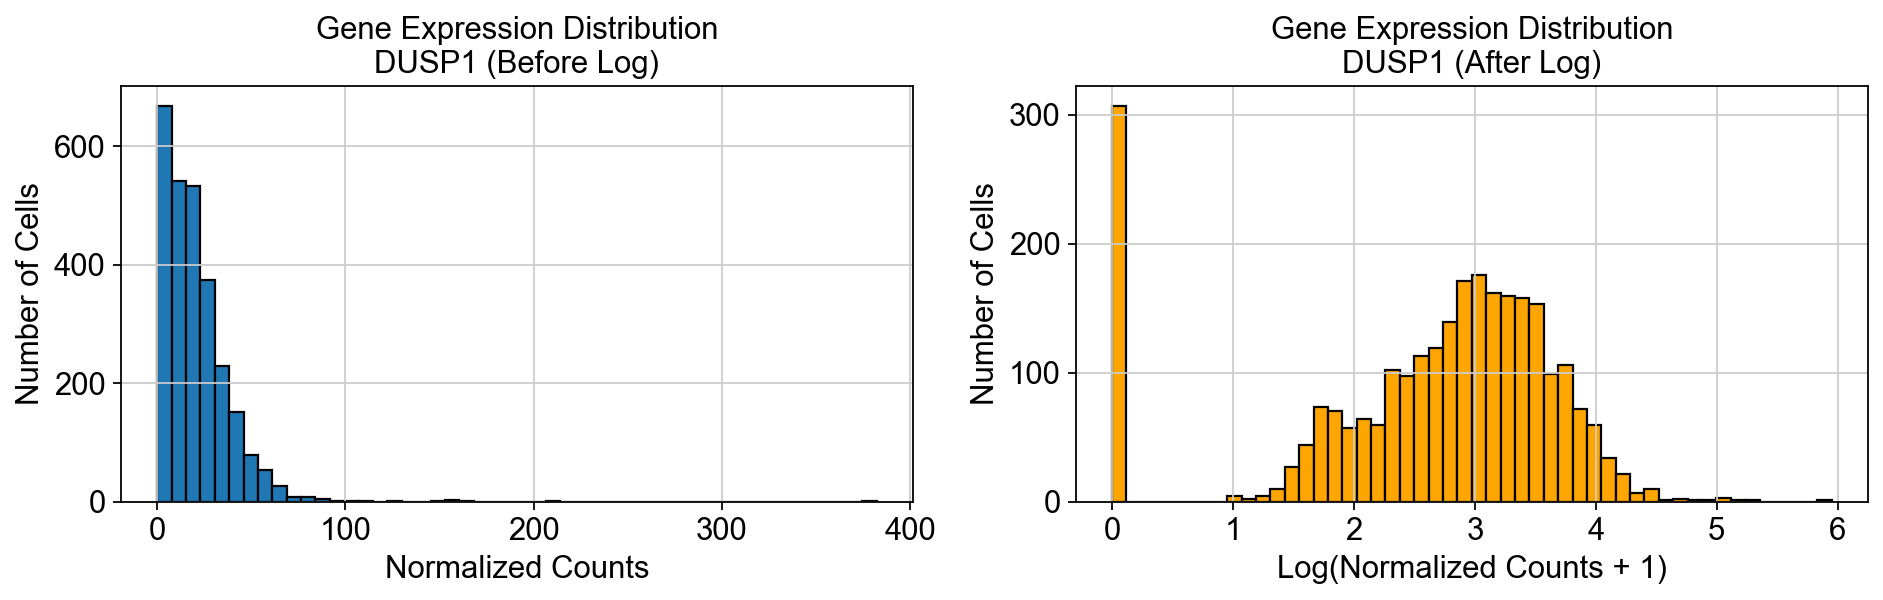

✅ Log transformation complete!
Gene used for visualization: DUSP1
Data is now log-normalized


In [4]:
# Visualize distribution before and after log transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Select a highly expressed gene for better visualization
if sp.issparse(adata.X):
    mean_expression = np.array(adata.X.mean(axis=0)).flatten()
else:
    mean_expression = adata.X.mean(axis=0)

# Find a gene with moderate-to-high expression
gene_idx = np.argsort(mean_expression)[-100]
gene_name = adata.var_names[gene_idx]

# Extract gene expression (before log)
if sp.issparse(adata.X):
    gene_expr_before = np.array(adata.X[:, gene_idx].toarray()).flatten()
else:
    gene_expr_before = adata.X[:, gene_idx]

# Before log transformation
axes[0].hist(gene_expr_before, bins=50, edgecolor='black')
axes[0].set_title(f'Gene Expression Distribution\n{gene_name} (Before Log)')
axes[0].set_xlabel('Normalized Counts')
axes[0].set_ylabel('Number of Cells')

# Log transform
sc.pp.log1p(adata)

# Extract gene expression (after log)
if sp.issparse(adata.X):
    gene_expr_after = np.array(adata.X[:, gene_idx].toarray()).flatten()
else:
    gene_expr_after = adata.X[:, gene_idx]

# After log transformation
axes[1].hist(gene_expr_after, bins=50, edgecolor='black', color='orange')
axes[1].set_title(f'Gene Expression Distribution\n{gene_name} (After Log)')
axes[1].set_xlabel('Log(Normalized Counts + 1)')
axes[1].set_ylabel('Number of Cells')

plt.tight_layout()
plt.savefig(f'{results_dir}02_log_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Log transformation complete!")
print(f"Gene used for visualization: {gene_name}")
print("Data is now log-normalized")

## 4. Identify Highly Variable Genes (HVGs)

### Why select highly variable genes?

**Problem**: Not all genes are informative
- ~13,000 genes in our dataset
- Many genes: constant expression across cells (housekeeping genes)
- Some genes: high variability = biological signal!

**Solution**: Select genes with high biological variance

**Three categories of genes**:
1. **Housekeeping genes**: Constant expression (e.g., ACTB, GAPDH) → Not informative
2. **Lowly expressed genes**: Mostly zeros, high technical noise → Not reliable
3. **Highly Variable Genes (HVGs)**: Variable expression → **Biological signal!**

**Benefits**:
- Reduces noise
- Focuses on biologically relevant genes
- Speeds up computation
- Improves clustering and visualization

**Typical selection**: Top 2,000-4,000 most variable genes

In [5]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor='seurat',
    batch_key=None
)

# Summary
print("=" * 60)
print("HIGHLY VARIABLE GENES SUMMARY")
print("=" * 60)
print(f"Total genes: {adata.n_vars}")
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")
print(f"Percentage: {100 * adata.var['highly_variable'].sum() / adata.n_vars:.1f}%")

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
HIGHLY VARIABLE GENES SUMMARY
Total genes: 13671
Highly variable genes: 2000
Percentage: 14.6%


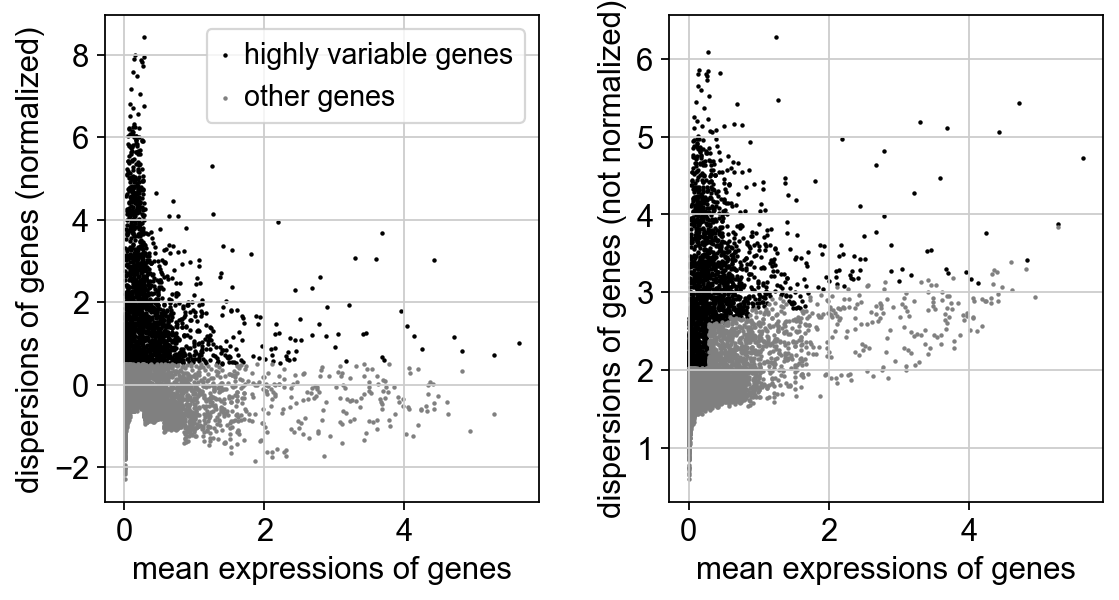

Highly variable genes identified!


In [6]:
# Visualize highly variable genes
sc.pl.highly_variable_genes(adata, show=False)
plt.savefig(f'{results_dir}02_highly_variable_genes.png', dpi=150, bbox_inches='tight')
plt.show()

print("Highly variable genes identified!")

## 5. Principal Component Analysis (PCA)

### Why PCA before scaling?

**Important**: PCA should be performed on **log-normalized data**, NOT scaled data!

**Reason**: 
- Scaling normalizes variance to 1 for each gene
- This removes the biological variance signal we want to capture
- PCA works best on log-normalized data where genes retain their natural variance

**What PCA does**:
- Reduces dimensionality: 2,000 genes → 50 principal components
- Captures maximum variance in fewer dimensions
- Removes noise (later PCs = technical noise)
- Essential for UMAP and clustering

**We compute PCA now** (on log-normalized HVGs) and **scale after** for other analyses.

In [7]:
# Save raw (log-normalized, unscaled) data
adata.raw = adata

# Compute PCA on log-normalized HVGs
print("=" * 60)
print("COMPUTING PCA")
print("=" * 60)
print(f"Total genes: {adata.n_vars}")
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")

# Subset to HVGs for PCA
adata_hvg = adata[:, adata.var['highly_variable']].copy()
print(f"Using {adata_hvg.n_vars} HVGs for PCA")

# Run PCA
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

# Copy PCA results back to main object
adata.obsm['X_pca'] = adata_hvg.obsm['X_pca']
adata.uns['pca'] = adata_hvg.uns['pca']

# Create empty PCA loadings for all genes, fill in HVGs
adata.varm['PCs'] = np.zeros((adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable'], :] = adata_hvg.varm['PCs']

# Print variance explained
cumvar = np.cumsum(adata.uns['pca']['variance_ratio'])
print("\n✅ PCA complete!")
print(f"Computed {adata.obsm['X_pca'].shape[1]} principal components")
print(f"\n📊 Variance explained:")
print(f"  - First 10 PCs: {cumvar[9]:.1%}")
print(f"  - First 20 PCs: {cumvar[19]:.1%}")
print(f"  - First 30 PCs: {cumvar[29]:.1%}")
print(f"  - First 50 PCs: {cumvar[49]:.1%}")

COMPUTING PCA
Total genes: 13671
Highly variable genes: 2000
Using 2000 HVGs for PCA
computing PCA
    with n_comps=50
    finished (0:00:00)

✅ PCA complete!
Computed 50 principal components

📊 Variance explained:
  - First 10 PCs: 20.3%
  - First 20 PCs: 23.3%
  - First 30 PCs: 26.0%
  - First 50 PCs: 30.8%


## 6. Scale Data (Optional, for other analyses)

### Why scale AFTER PCA?

**Scaling** centers each gene to mean=0 and scales to std=1.

**When to scale**:
- For some downstream analyses (e.g., differential expression)
- For visualization of specific genes
- NOT needed for PCA (already done!)
- NOT needed for UMAP/clustering (they use PCA space)

**Note**: We scale here for completeness, but it's optional. The PCA coordinates are what matter for downstream analysis.

In [8]:
# Scale data (optional)
sc.pp.scale(adata, max_value=10)

print("Data scaled!")
print("Mean = 0, Std = 1 for each gene")
print(f"Clipped values to max = 10 (removes extreme outliers)")

Data scaled!
Mean = 0, Std = 1 for each gene
Clipped values to max = 10 (removes extreme outliers)


/opt/anaconda3/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## 7. Save Preprocessed Data

Save the preprocessed data with PCA for downstream analysis.

In [9]:
# Save preprocessed data
adata.write(f'{data_dir}pbmc3k_preprocessed.h5ad')

print("✅ Preprocessed data saved!")
print(f"File: {data_dir}pbmc3k_preprocessed.h5ad")
print(f"Final dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"HVGs: {adata.var['highly_variable'].sum()}")
print(f"PCA: {adata.obsm['X_pca'].shape[1]} components computed")

✅ Preprocessed data saved!
File: ../data/pbmc3k_preprocessed.h5ad
Final dimensions: 2689 cells × 13671 genes
HVGs: 2000
PCA: 50 components computed


## 📋 Summary

### ✅ What we accomplished:

1. **Loaded filtered data** (2,689 cells × 13,671 genes)
2. **Normalized counts** to 10,000 per cell (CPM normalization)
3. **Log transformed** data to stabilize variance
4. **Identified 2,000 highly variable genes** (HVGs)
5. **Computed PCA** on log-normalized HVGs (50 components)
   - First 30 PCs capture ~26% of variance
6. **Scaled data** (optional, for other analyses)
7. **Saved preprocessed data** for downstream analysis

### 📊 Data transformations:

| Step | Purpose | Result |
|------|---------|--------|
| **Normalization** | Account for sequencing depth | Cells are comparable |
| **Log transform** | Stabilize variance | Better distribution |
| **HVG selection** | Focus on biological signal | 2,000 informative genes |
| **PCA** | Dimensionality reduction | 50 components |
| **Scaling** | Optional standardization | Mean=0, Std=1 |

### 🎯 Key Insight:

**PCA is computed on log-normalized data (NOT scaled)** because scaling removes the variance signal we want to capture!

### 🚀 Next steps: Notebook 03 - Dimensionality Reduction

In the next notebook, we will:
1. **Visualize PCA** results
2. **Compute UMAP** for 2D visualization
3. **Compute t-SNE** (alternative visualization)
4. **Interpret** principal components

---

**🎉 Excellent work! Your data is now ready for visualization and clustering!**